In [1]:
from __future__ import annotations

import argparse
import json
import pickle
from typing import Tuple
import time
import os
os.environ['LOG_LEVEL'] = 'ERROR'

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from gauntlet.coingecko import CoinGecko
from gauntlet.constants import STABLECOINS
from gauntlet.data_utils import get_drawdowns
from gauntlet.data_utils import get_price_impacts
from gauntlet.logger import get_logger
from gauntlet.sim import get_init_collateral_usd
from gauntlet.sim import heuristic_drawdown
from gauntlet.sim import simulate_insolvency
from gauntlet.coingecko import token_from_symbol_or_address
from gauntlet.tokens import Tokens, Token
from gauntlet.sim import compute_liquidation_incentive
from gauntlet.coingecko import current_price

## Max Drawdown, LLTV vs Bad Debt


Collateral LINK | Borrow USDC | Initial collateral: 50.00mil | Repay: 0.1775mil


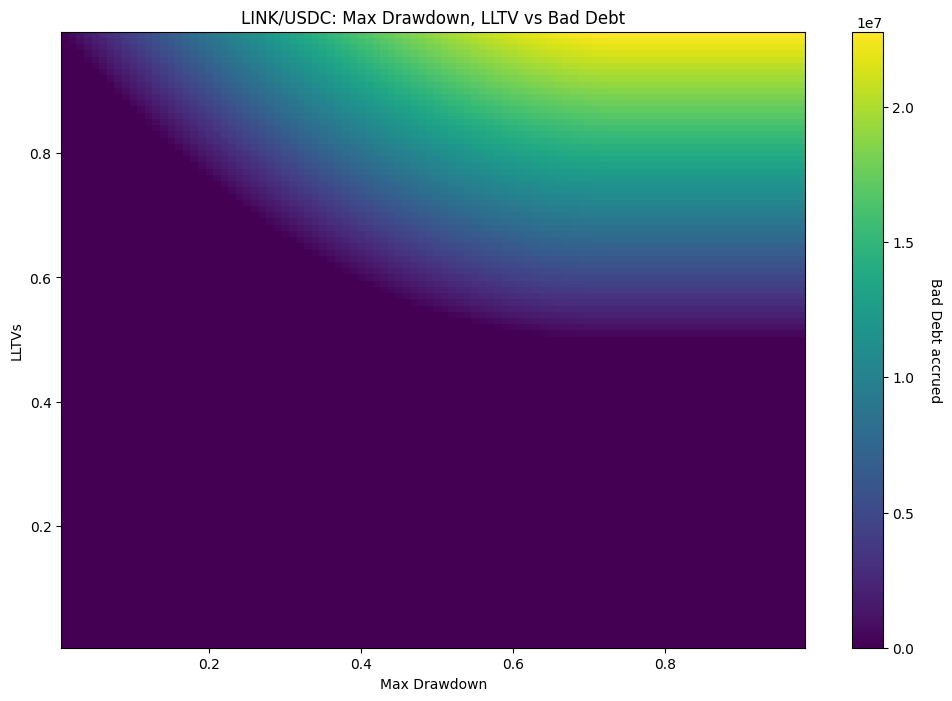

In [2]:
def drawdown_vs_lltv(collat: Token, debt: Token):
    '''
    Compute a heatmap of max drawdown and recommended LLTV against bad debt accrued
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    tokens = [collat, debt]
    result_array = np.zeros((len(lltvs), len(max_drawdowns)))
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, Tokens.USDC, price_impacts)
    print(f"Collateral {collat.symbol.upper()} | Borrow {debt.symbol.upper()} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    
    for i, ltv in enumerate(lltvs):
        for j, dd in enumerate(max_drawdowns):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=min(repay_amnts[collat], repay_amnts[debt]),
                liq_bonus=lb,
                max_drawdown=dd,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins
    
    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(max_drawdowns, lltvs, result_array, cmap='viridis', shading='auto')
    colorbar = plt.colorbar(c)
    colorbar.set_label('Bad Debt accrued', rotation=270, labelpad=20)
    
    plt.xlabel('Max Drawdown')
    plt.ylabel('LLTVs')
    plt.title(f'{collat.symbol.upper()}/{debt.symbol.upper()}: Max Drawdown, LLTV vs Bad Debt')
    plt.show()

drawdown_vs_lltv(Tokens.LINK, Tokens.USDC)

As the max drawdown increases, the amount of bad debt accrued also increases and correspondingly, the recommended LLTV decreases.

# Initial Collateral Size, LLTV vs Bad Debt

Collateral LINK | Borrow USDC | Initial collateral: 50.00mil | Repay: 0.1775mil


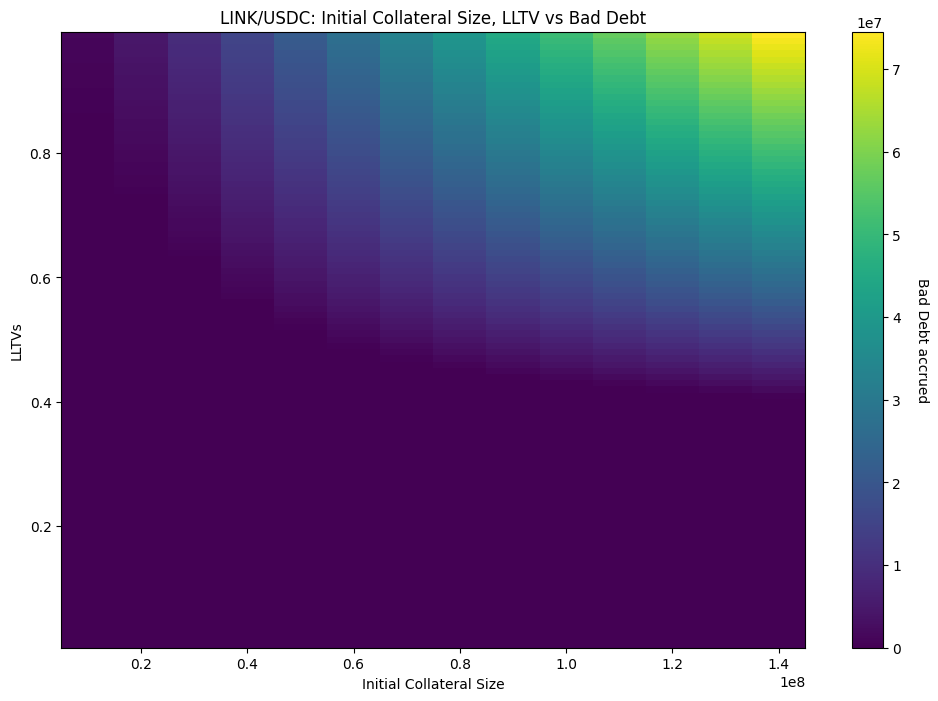

In [3]:
def collateral_size_vs_lltv(collat: TokenInfo, debt: TokenInfo):
    '''
    Compute a heatmap of the initial collateral size's impact against recommended LLTV.
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    tokens = [collat, debt]
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, Tokens.USDC.address, price_impacts)

    print(f"Collateral {collat.symbol.upper()} | Borrow {debt.symbol.upper()} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    init_collats = [10_000_000 * i for i in range(1, 15)]
    result_array = np.zeros((len(lltvs), len(init_collats)))
    
    for i, ltv in enumerate(lltvs):
        for j, initial_collateral_usd in enumerate(init_collats):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=min(repay_amnts[collat], repay_amnts[debt]),
                liq_bonus=lb,
                max_drawdown=0.6,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins

    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(init_collats, lltvs, result_array, cmap='viridis', shading='auto')
    colorbar = plt.colorbar(c)
    colorbar.set_label('Bad Debt accrued', rotation=270, labelpad=20)
    
    plt.xlabel('Initial Collateral Size')
    plt.ylabel('LLTVs')
    plt.title(f'{collat.symbol.upper()}/{debt.symbol.upper()}: Initial Collateral Size, LLTV vs Bad Debt')
    plt.show()
    
collateral_size_vs_lltv(Tokens.LINK, Tokens.USDC)

Initializing the simulation with a larger initial collateral size means that we need to repay more debt over the course of the simulation. Assuming the repay amount does not change while we increase the initial collateral size, we would expect to see more bad debt accrued as we are unable to liquidate the position quick enough before the debt value outpaces the collateral value. The heatmap above shows the general trend of larger initial collateral positions leading to a lower recommended LLTV.

# Repay Size, LLTV vs Bad Debt

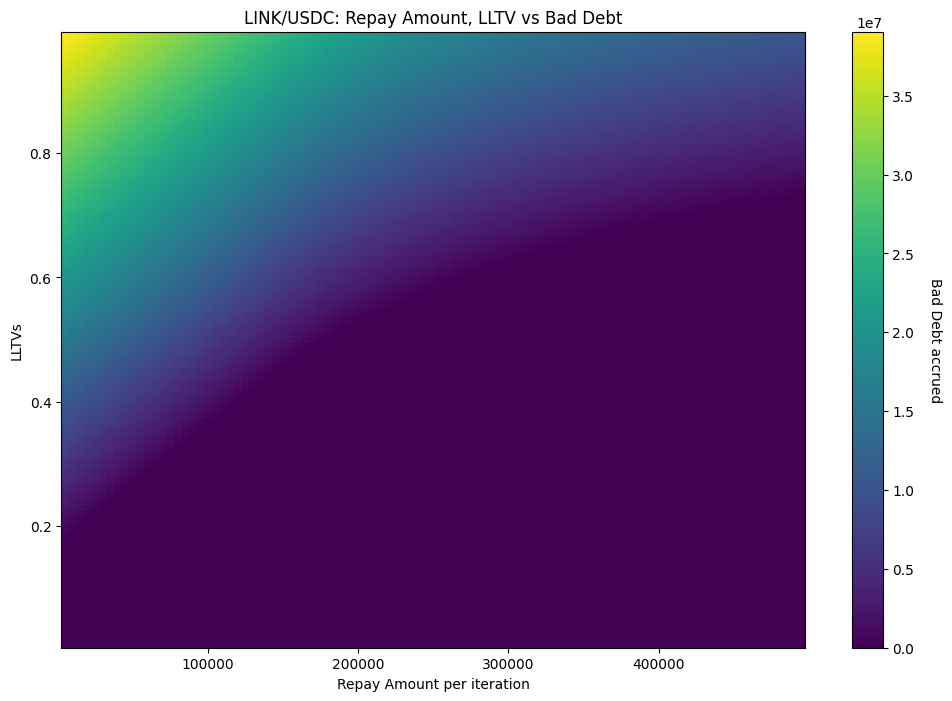

In [4]:
def repay_size(collat: TokenInfo, debt: TokenInfo):
    '''
    Compute a heatmap of the repay size's impact against recommended LLTV.
    '''
    lltvs = np.arange(0.01, 1.0, 0.01)
    max_drawdowns = np.arange(0.01, 0.99, 0.01)
    m = 0.15
    beta = 0.3
    pct_decrease = 0.005
    debt = Tokens.USDC
    tokens = [collat, debt]
    
    # default values from historical drawdown, price impact
    prices = {t: current_price(t.address) for t in tokens}  
    price_impacts = get_price_impacts(                                                                 
        [collat, debt], update_cache=False, use_cache=True                               
    )              
    repay_amnts = {t: price_impacts[t.symbol]["0.005"] * prices[t] for t in tokens} 
    initial_collateral_usd = get_init_collateral_usd(collat, debt, price_impacts)
    
    # print(f"Collat {collat} | Borrow {debt} | Initial collateral: {initial_collateral_usd / 1e6:.2f}mil | Repay: {repay_amnts[collat]/1e6:.4f}mil")
    repays = [5_000 * i for i in range(1, 100)]
    result_array = np.zeros((len(lltvs), len(repays)))
    
    for i, ltv in enumerate(lltvs):
        for j, r in enumerate(repays):
            lb = compute_liquidation_incentive(m, beta, ltv)
            ins = simulate_insolvency(
                initial_collateral_usd=initial_collateral_usd,
                collateral_price=current_price(collat.address),
                debt_price=1,
                lltv=ltv,
                repay_amount_usd=r,
                liq_bonus=lb,
                max_drawdown=0.8,
                pct_decrease=pct_decrease,
            )
            result_array[i, j] = ins

    plt.figure(figsize=(12, 8))
    c = plt.pcolormesh(repays, lltvs, result_array, cmap='viridis', shading='auto')
    colorbar = plt.colorbar(c)
    colorbar.set_label('Bad Debt accrued', rotation=270, labelpad=20)
    
    plt.xlabel('Repay Amount per iteration')
    plt.ylabel('LLTVs')
    plt.title(f'{collat.symbol.upper()}/{debt.symbol.upper()}: Repay Amount, LLTV vs Bad Debt')

    plt.show()
    
repay_size(Tokens.LINK, Tokens.USDC)

If the amount of debt liquidated at each iteration of the simulation is too small, we will not be able to pay off the borrower's debt fast enough before the debt value is larger than the collateral value. The heatmap shows the recommended LLTV increasing as the repay amount increases. This aligns with our expectations of market dynamics: when there is a healthy market for liquidations, there is less risk for bad debt accrual.

## Running the Risk Tool
Below we demonstrate the cli command for getting the recommended LLTV and how we might change our assumptions in the simulation

In [5]:
!LOG_LEVEL=INFO python main.py --collateral weth --borrow usdc

[2023-09-08 04:00:34,158][INFO][main.py:111] Starting
[2023-09-08 04:00:34,427][INFO][sim.py:179] Initial collateral: 360.38mil | Repay usd: 20904419.67 | Max drawdown: 0.40
[2023-09-08 04:00:34,428][INFO][main.py:105] Collateral: weth | Debt: usdc | LI: 0.021 | LLTV: 0.930


In the above, the recommended LLTV for a WETH collateral, USDC borrow market was 0.93.

## Adjusting the Risk Tool Assumptions
WETH is a fairly liquid asset an LLTV that is this high may be warranted. However, if a user is more risk averse, they may want to see how the results might look like if they adjusted the drawdown and repay amount assumptions. Increasing the max drawdown to 70% and decreasing the amount repaid to $5million will yield a lower LLTV:

In [6]:
!LOG_LEVEL=INFO python main.py --collateral weth --borrow usdc --max_drawdown 0.7 --repay_amount_usd 5_000_000

[2023-09-08 04:00:34,895][INFO][main.py:111] Starting
[2023-09-08 04:00:35,117][INFO][sim.py:179] Initial collateral: 360.38mil | Repay usd: 5000000.00 | Max drawdown: 0.70
[2023-09-08 04:00:35,117][INFO][main.py:105] Collateral: weth | Debt: usdc | LI: 0.067 | LLTV: 0.790


With a larger max drawdown and lower repay amount, we see that the recommended LLTV has decreased to 0.79.